## (1) Data Description:

### Dataset Overview

| File           | Purpose                                 | Rows (Observations) | Columns (Variables) |
| -------------- | --------------------------------------- | ------------------- | ------------------- |
| `sessions.csv` | Gameplay session logs per user          | **1535**            | **5**               |
| `players.csv`  | Player demographic & membership profile | **196**             | **7**               |

The datasets appear linked through a **hashedEmail**

---

### Variable Summary

#### **`sessions.csv` Variables**

| Variable              | Type (Inferred)                     | Description                        |
| --------------------- | ----------------------------------- | ---------------------------------- |
| `hashedEmail`         | Categorical (string)                | Anonymized unique user identifier  |
| `start_time`          | String (datetime, needs conversion) | Start time of the recorded session |
| `end_time`            | String (datetime, needs conversion) | End time of the recorded session   |
| `original_start_time` | Numeric (Unix timestamp, ms)        | Original system-logged start time  |
| `original_end_time`   | Numeric (Unix timestamp, ms)        | Original system-logged end time    |

---

### **`players.csv` Variables**

| Variable       | Type (Inferred)                                   | Description                                        |
| -------------- | ------------------------------------------------- | -------------------------------------------------- |
| `experience`   | Ordinal categorical (Beginner → Pro)              | Skill level                                        |
| `subscribe`    | Boolean categorical                               | Whether user is subscribed (True/False)            |
| `hashedEmail`  | Categorical (key)                                 | Unique encrypted identifier (matches sessions.csv) |
| `played_hours` | Numeric (continuous)                              | Total lifetime playtime                            |
| `name`         | Categorical                                       | Player alias                                       |
| `gender`       | Categorical                                       | Gender identification                              |
| `Age`          | Numeric (continuous)                              | Age in years                                       |

---

### Summary Statistics

#### **Numeric Variables – Sessions**

| Metric  | `original_start_time` | `original_end_time` |
| ------- | --------------------- | ------------------- |
| Count   | 1535                  | 1533                |
| Mean    | 1.71920e+12           | 1.71920e+12         |
| Std Dev | 3.56e+09              | 3.55e+09            |
| Min     | 1.71240e+12           | 1.71240e+12         |
| 25%     | 1.71624e+12           | 1.71624e+12         |
| Median  | 1.71920e+12           | 1.71918e+12         |
| 75%     | 1.72189e+12           | 1.72189e+12         |
| Max     | 1.72733e+12           | 1.72734e+12         |

**Timestamps are in milliseconds and need conversion**

---

#### **Numeric Variables – Players**

| Metric  | `played_hours` | `Age` |
| ------- | -------------- | ----- |
| Count   | 196            | 194   |
| Mean    | 6.19           | 21.14 |
| Std Dev | 17.83          | 7.39  |
| Min     | 0.00           | 9.00  |
| 25%     | 0.10           | 17.00 |
| Median  | 0.60           | 19.00 |
| 75%     | 2.30           | 22.75 |
| Max     | 223.10         | 58.00 |

---

### Data Quality Observations & Issues

#### Observations

* Both datasets share a unique key connecting them
* No apparent duplicates in players

#### Issues

| Issue                               | Explanation                                     |
| ----------------------------------- | ----------------------------------------------- |
| Datetime stored as text             | Needs conversion to proper datetime objects     |
| Some missing values                 | `end_time` and `Age` missing for some records   |
| Potential fake names                | Every name is unique, uncommon distribution     |
| Single-time-unit timestamps unclear | `original_*` likely needs rescaling or timezone |
| No session duration field           | Requires calculated metric                      |

---

#### Possible Unseen Issues

* Player accounts may be shared between multiple real humans
* Sessions could include idle time 
* Mixed device/platform logging formats could influence timestamps
* Experience level might be self-reported → **biased**
* No validation that `played_hours` = sum of session durations
* True identities unknown — **unverifiable demographics**
* Time drift between `start_time` and `original_start_time` sources

---

### How Data Were Likely Collected

Based on structure, this appears to be:

1. **Automated telemetry logging** from the game
2. Player demographic survey 
3. Session logs stored passively with timestamps
4. Later exported to CSV for analysis

## (2) Questions:

### Can "experience" predict "played hours" in players.csv?
Using linear regression, the experience variable is first converted into an numeric scale (for example, Beginner = 0, Amateur = 1, Regular = 2, Veteran = 3, Pro = 4) so that its progression can be interpreted mathematically. This experience value is then used as the X value in the regression model, while future played hours serves as the Y value. The regression algorithm fits a line of best fit through the data points by estimating coefficients that describe the relationship between experience and playtime. In order to wrangle a text file with these values, the first step is to read the csv and remove all the unneeded fields. The only fields to be kept are exclusively experience and played hours. Next, experience has to be converted into a numeric scale, assigning numbers to each predetermined string. Lastly, to prevent extreme skew, it might be needed to perform a log transform on the number of hours played. 

## (3) Exploratory Data Analysis and Visualization:

In [4]:
library(repr)
library(tidyverse)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_played_hours,mean_age
<dbl>,<dbl>
5.845918,21.13918


Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


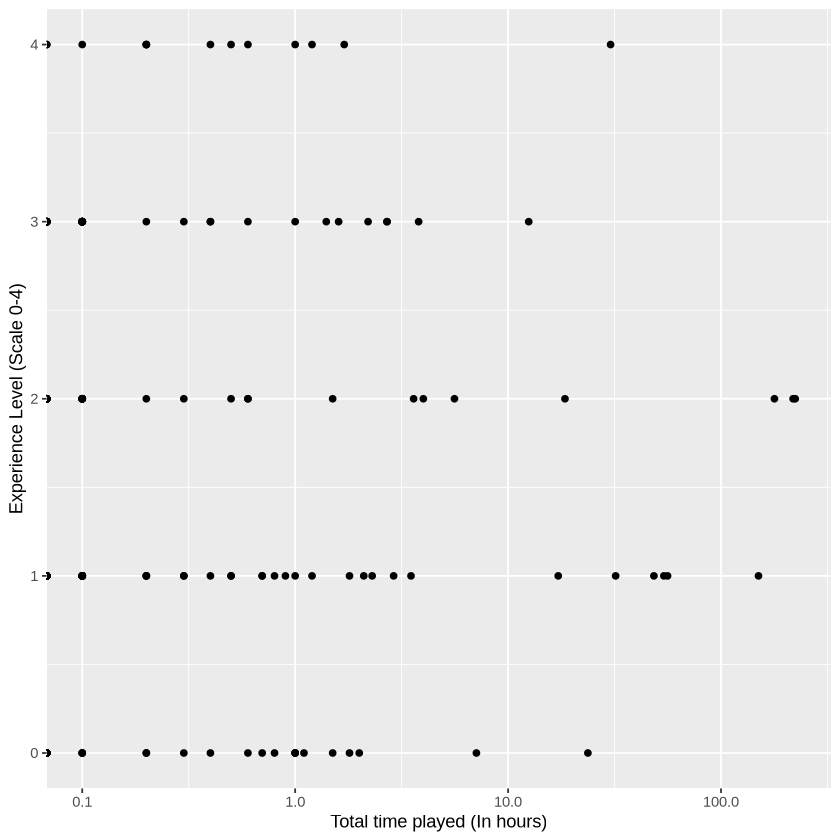

In [28]:
df = read_csv("https://raw.githubusercontent.com/ubc-danielX/dsci-100-2025w1-group-008-13/refs/heads/main/players.csv")
# find the mean of hours played and age
mean_played <- mean(df$played_hours, na.rm = TRUE)
mean_age <- mean(df$Age, na.rm = TRUE)
mean_summary <- df |> summarise(
                mean_played_hours = mean(played_hours, na.rm = TRUE),
                mean_age = mean(Age, na.rm = TRUE),
                )
mean_summary

# getting a plot of current data
df_new <- df |>
  mutate(experience_num = case_when(
    experience == "Beginner"  ~ 0,
    experience == "Amateur"   ~ 1,
    experience == "Regular"   ~ 2,
    experience == "Veteran"   ~ 3,
    experience == "Pro"       ~ 4
  )) # converting the experience strings to actual numbers

experience_hours <- df_new |>
  select(experience_num, played_hours)

df_plot <- experience_hours |>
     ggplot(aes(x = played_hours, y = experience_num)) + 
         geom_point() + 
         xlab("Total time played (In hours)") +
         ylab("Experience Level (Scale 0-4)") +
         scale_x_log10()
df_plot # plotting

## Notes
A problem that has occured in the graph is the large amount of individuals who have logged 0 total hours played on the server. Originally I wanted to include them but it occured to me since this data is supposed to corrolate to players who play on the server, individuals who have not logged any time are considered not eligible for consideration and have hence been removed as an outlier. Otherwise they would skew the results by a large margin regardless of skill level (not actually being part of the study). They haven't even logged on! As the canvas says to only wrangle the bare minimum, I have opted to keep them here for now.

## (4) Methods and Plan:

### Why is linear regression appropriate?

Linear regression is appropriate when you want to **predict a continuous outcome** (`played_hours`) from one or more predictors (`experience_num`).

* Here, `played_hours` is continuous (numeric), and we’ve converted `experience` to a numeric scale (0–4).
* Linear regression will estimate a **linear relationship**, i.e., it assumes that as experience increases, the expected played hours change in a linear fashion.
* It’s simple, interpretable, and widely used for exploratory analysis of relationships between variables.

---

### Assumptions required for linear regression

1. **Linearity:** The relationship between `experience_num` and `played_hours` is linear.
2. **Independence:** Each observation (player) is independent of the others.

---

### Potential limitations or weaknesses

* **Linearity assumption may not hold:** Experience may not have a strictly linear effect on played hours. Maybe beginners and pros play more, while intermediates play less → relationship could be nonlinear.
* **Outliers:** Extreme values in `played_hours` can heavily influence the regression.
* **Skewed data:** If many players have zero hours, residuals may not be normally distributed.
* **Single predictor limitation:** Only using experience ignores other potentially important factors (age, gender, subscription, etc.).
* **Causality:** Regression only captures association, not causation.

---

### How to compare and select the model

* **R² (coefficient of determination):** Measures how much variation in `played_hours` is explained by `experience_num`.
* **Residual plots:** Check for nonlinearity and patterns.

---

### How to process the data

**Step 1: Clean the data**

* Convert `experience` → `experience_num`.
* Deal with outliers

**Step 2: Split the data**

* Common approach: **train-test split**.

  * Example: 70% train, 30% test.
  * Randomly sample rows.
* Optionally, use a **k-fold cross-validation** (e.g., k = 5 or 10).

**Step 3: Apply linear regression**

* Fit the model on the training set.
* Evaluate performance on the test set

**Step 4: Optional transformations**

* If residuals are skewed or variance is unequal, consider **log-transforming `played_hours`**.